In [1]:
# https://github.com/eriklindernoren/PyTorch-GAN#gan
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pylab as plt


In [2]:
n_epochs = 10
batch_size = 128 
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 4 
latent_dim  = 100 
img_size = 28 
channels = 1
sample_interval = 400 

In [3]:
img_shape = (channels, img_size, img_size)
cuda = True if torch.cuda.is_available() else False

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(latent_dim, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), 
            nn.BatchNorm1d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024), 
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),

        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [10]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


In [11]:
# Configure data loader
#os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


In [12]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [13]:
losses_g = []
losses_d = []
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        losses_g.append(g_loss.item())
        losses_d.append(d_loss.item())

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(1-gen_imgs.data[:25], "data/gan-mnist-%d.png" % batches_done, nrow=5, normalize=True)
    
    print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, d_loss.item(), g_loss.item())
        )


[Epoch 0/10] [D loss: 0.485226] [G loss: 1.312627]
[Epoch 1/10] [D loss: 0.298519] [G loss: 1.289741]


KeyboardInterrupt: 

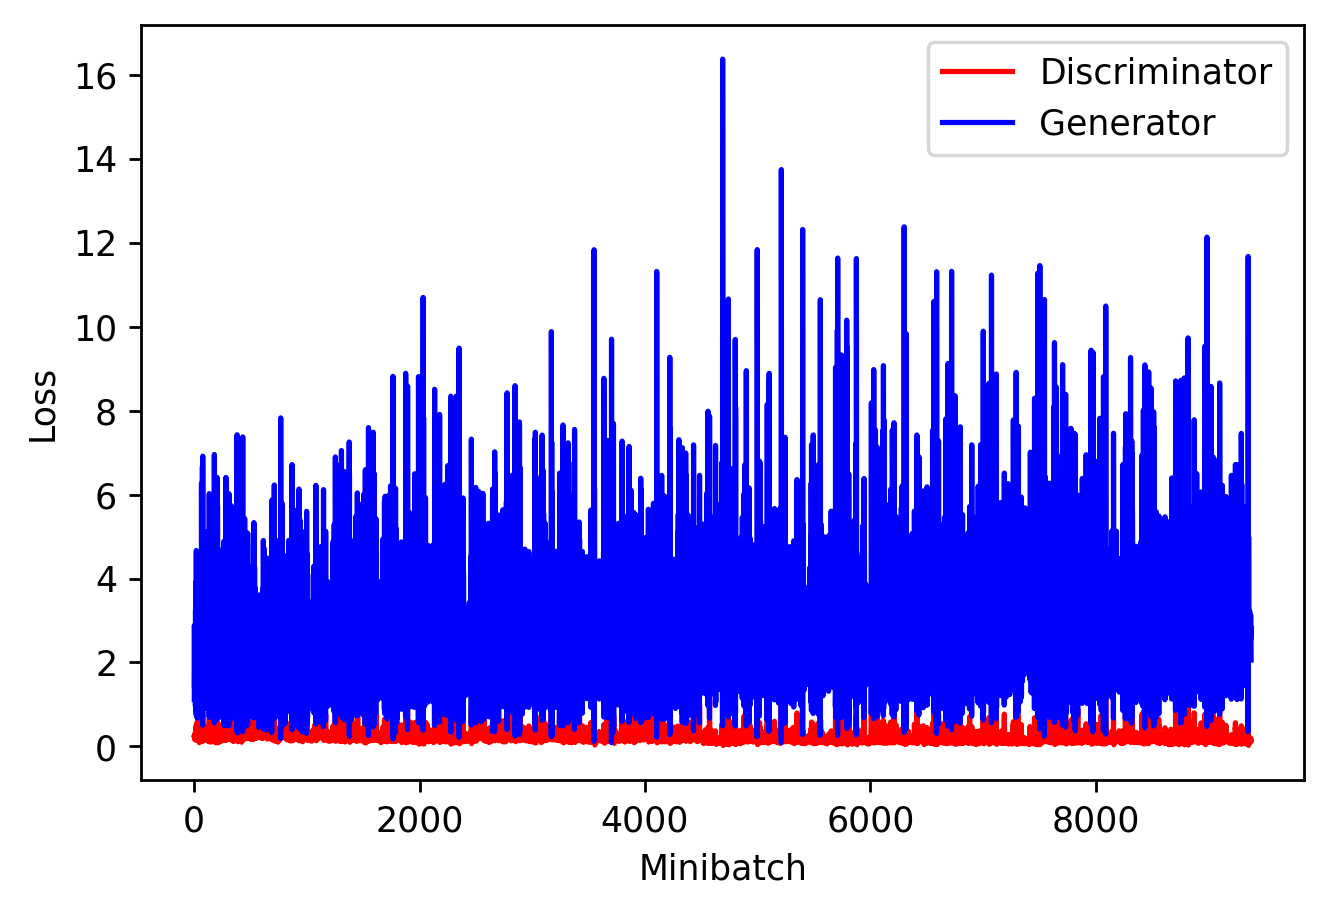

In [19]:
plt.figure(dpi=250)
plt.plot(losses_d, 'r', label='Discriminator')
plt.plot(losses_g, 'b', label='Generator')
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.legend()

In [16]:
a = [1,2,3]

In [18]:
print(a)

[1, 2, 3]
